<a href="https://colab.research.google.com/github/da-roth/StableAndBiasFreeMonteCarloGreeks/blob/main/src/BFS_Examples/bfs_digital_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
%%capture
!pip install plotsurfacetool

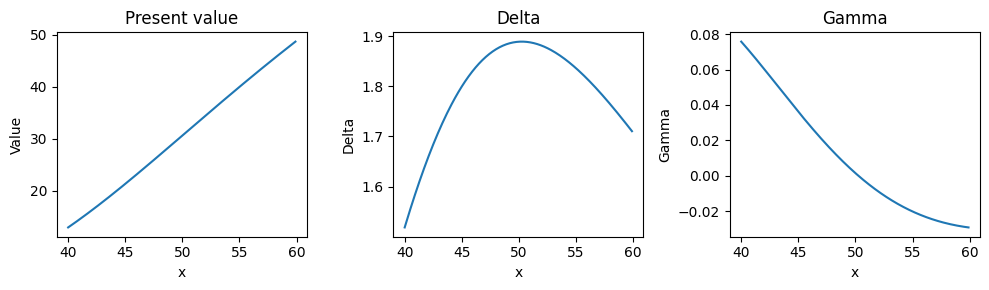

In [2]:
from scipy.stats import norm
import torch
from plotsurfacetool import *

class DigitalCallPricer:

    @staticmethod
    def bs_digital_closed(s_0, t_0, T, r, sigma, K, q = 0):
        # see e.g. https://en.wikipedia.org/wiki/Binary_option
        # Here: up-and-out digital call, or "Asset or nothing call"
        # This pays out one unit of spot if the spot is above the strike at maturit
        tau = T - t_0
        # Vanilla price
        d1 = (np.log(s_0/K) + (r-q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d2 = (np.log(s_0/K) + (r-q - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        # up and out price
        return s_0 * np.exp(-q * tau) * norm.cdf(d1)

    @staticmethod
    def Standard_MC(s_0, t_0, T, r, sigma, K, N):
        PV, _ = DigitalCallPricer.Standard_MC_Digital_torch(s_0, DigitalCallPricer.path_update_GBM, t_0, T, r, sigma, K, N)
        return PV

    @staticmethod
    def Standard_MC_torch(s_0, t_0, T, r, sigma, K, N):
        return DigitalCallPricer.Standard_MC_Digital_torch(s_0, DigitalCallPricer.path_update_GBM, t_0, T, r, sigma, K, N)

    @staticmethod
    def BFS_MC(s_0, t_0, T, r, sigma, K, N):
        PV, _ = DigitalCallPricer.bfc_MC_torch(s_0, DigitalCallPricer.path_update_GBM, t_0, T, r, sigma, K, N)
        return PV

    @staticmethod
    def BFS_MC_torch(s_0, t_0, T, r, sigma, K, N):
        return DigitalCallPricer.bfc_MC_torch(s_0, DigitalCallPricer.path_update_GBM, t_0, T, r, sigma, K, N)

    @staticmethod
    def Standard_MC_Digital_torch(s_0, path_update_method, t_0, T, r, sigma, K, N):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)

        # Simulartion
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch_t0 = s_0_torch.expand(N_torch).clone()
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch

        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        s_torch = path_update_method(s_torch, dt_torch, z_torch, r_torch, sigma_torch)
        index = (torch.isnan(V) & (s_torch < K_torch))
        V[index] = 0.0

        #Payoff calculation
        index = torch.isnan(V)
        V[index] = torch.exp(-r_torch * T_torch) * s_torch[index]

        V = torch.sum(V[index]) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def bfc_MC_torch(s_0, path_update_method, t_0, T, r, sigma, K, N):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)
        two_torch = torch.tensor(2.0, device=device)
        # Simulation
        survival_prob = torch.full((N_torch,), 1.0, dtype=torch.float64, device=device)
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch

        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        # new try:
        u_torch = 0.5 * (1 + torch.erf(z_torch / torch.sqrt(torch.tensor(2.0))))
        oss_prob = 0.5 * (torch.erf((torch.log(K_torch / s_torch) - (r_torch - 0.5 * sigma_torch**2) * dt_torch) / (sigma_torch * torch.sqrt(dt_torch)) / torch.sqrt(two_torch)) + 1.0)
        s_torch_new = s_torch * torch.exp((r_torch- 0.5 * sigma_torch**2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * torch.erfinv(2 * ((1-oss_prob) * u_torch + oss_prob) - 1) * torch.sqrt(two_torch))

        #Payoff calculation
        V = (1 - oss_prob) * torch.exp(-r_torch * T_torch) * s_torch_new
        V = torch.sum(V) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def path_update_GBM(s_torch, dt_torch, z_torch, r_torch, sigma_torch):
        return s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

# Define constants as class attributes
t_0 = 0.0
T = 1.0
r = 0.04
sigma = 0.3
K = 50
N = 40000

closed_solution = lambda s_0: DigitalCallPricer.bs_digital_closed(s_0, t_0, T, r, sigma, K)
standard_MC_FD = lambda s_0: DigitalCallPricer.Standard_MC(s_0, t_0, T, r, sigma, K, N)
standard_MC_AAD = lambda s_0: DigitalCallPricer.Standard_MC_torch(s_0, t_0, T, r, sigma, K, N)
bfs_MC_FD = lambda s_0: DigitalCallPricer.BFS_MC(s_0, t_0, T, r, sigma, K, N)
bfs_MC_AAD = lambda s_0: DigitalCallPricer.BFS_MC_torch(s_0, t_0, T, r, sigma, K, N)

plotSettings = PlotSettings()
plotSettings.set_S0Array(np.arange(40.0, 60.0, 0.1))
plotSettings.set_FiniteDifferencesStepWidth(0.0001)
plotSettings.set_OutputStatistic(OutputStatistic.Gamma)

# Closed solution
PlotSurfaceTool.Run(closed_solution, plotSettings)

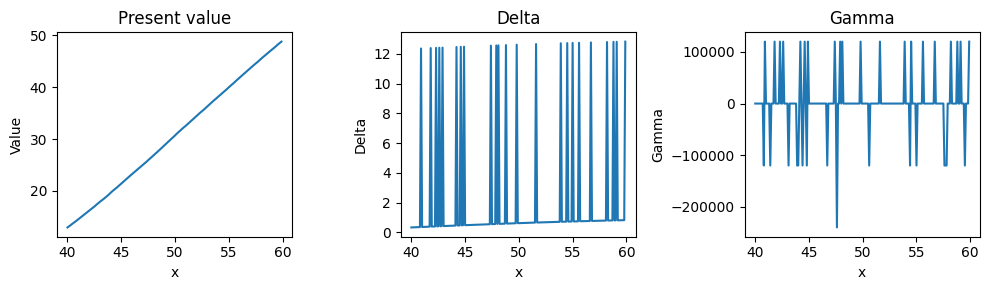

In [3]:
# Standard Monte Carlo using FD
PlotSurfaceTool.Run(standard_MC_FD, plotSettings)

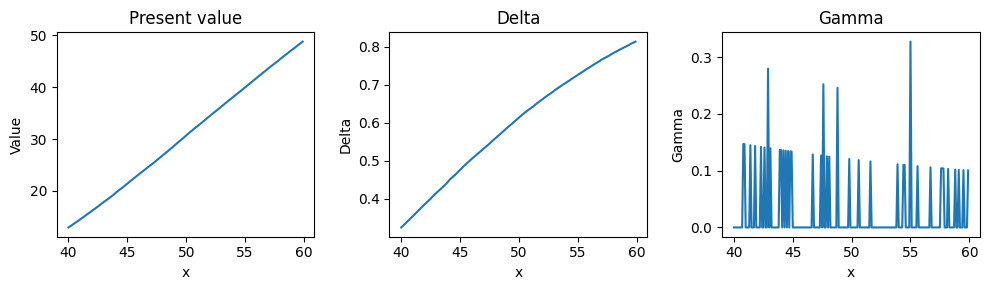

In [4]:
#Standard Monte Carlo using AAD
PlotSurfaceTool.Run(standard_MC_AAD, plotSettings)

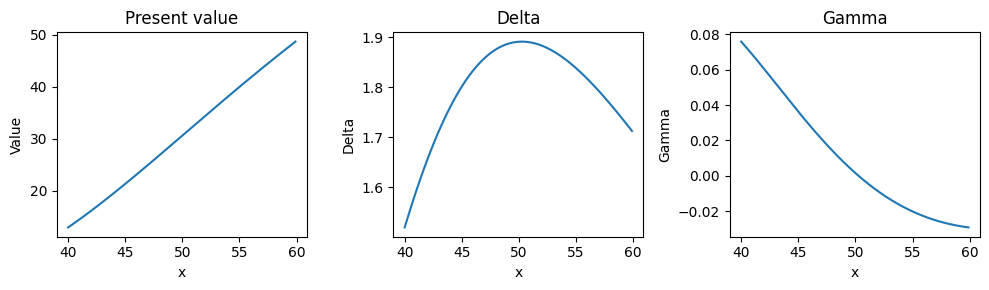

In [5]:
# BFS Monte Carlo estimator using FD
PlotSurfaceTool.Run(bfs_MC_FD, plotSettings)

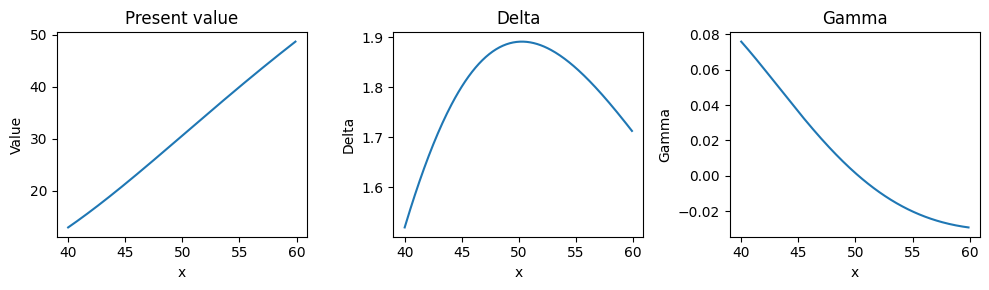

In [6]:
# BFS Monte Carlo estimator using FD
PlotSurfaceTool.Run(bfs_MC_AAD, plotSettings)